In [50]:
%pip install yfinance finta Jinja2 xgboost imbalanced-learn seaborn 

Note: you may need to restart the kernel to use updated packages.


In [51]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tickerData import *
from mlAlgorithms import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [52]:
df = getTickerData(ticker="btc-usd", period="720d", interval="1h")
df.drop(columns={'Adj Close'}, inplace=True)
df.rename(columns={'Date':'date', 'Open':'open', 'High':'high','Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)
df = exponential_smooth(df, 0.65)

[*********************100%***********************]  1 of 1 completed


In [53]:
#indicator_list = ""
#with open('indicators.txt', 'r') as indicators:
#    indicator_list = indicators.read().replace("'", '"')
#indicator_list = re.findall(r'"([^"]*)"', indicator_list)

In [54]:
indicators = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX', 'VAMA', 'ZLEMA', 'VWAP', 'PPO', 'ATR', 'DMI', 'PIVOT_FIB', 'CFI', 'WTO']
df = getTickerIndicatorData(df, indicators, dropna=True)

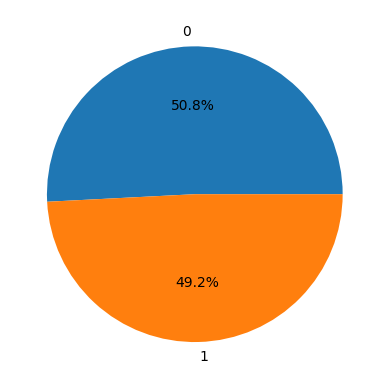

In [55]:
df = produce_prediction(df, 24, dropna=True, removeohl=True)
plt.pie(df['pred'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

<Axes: >

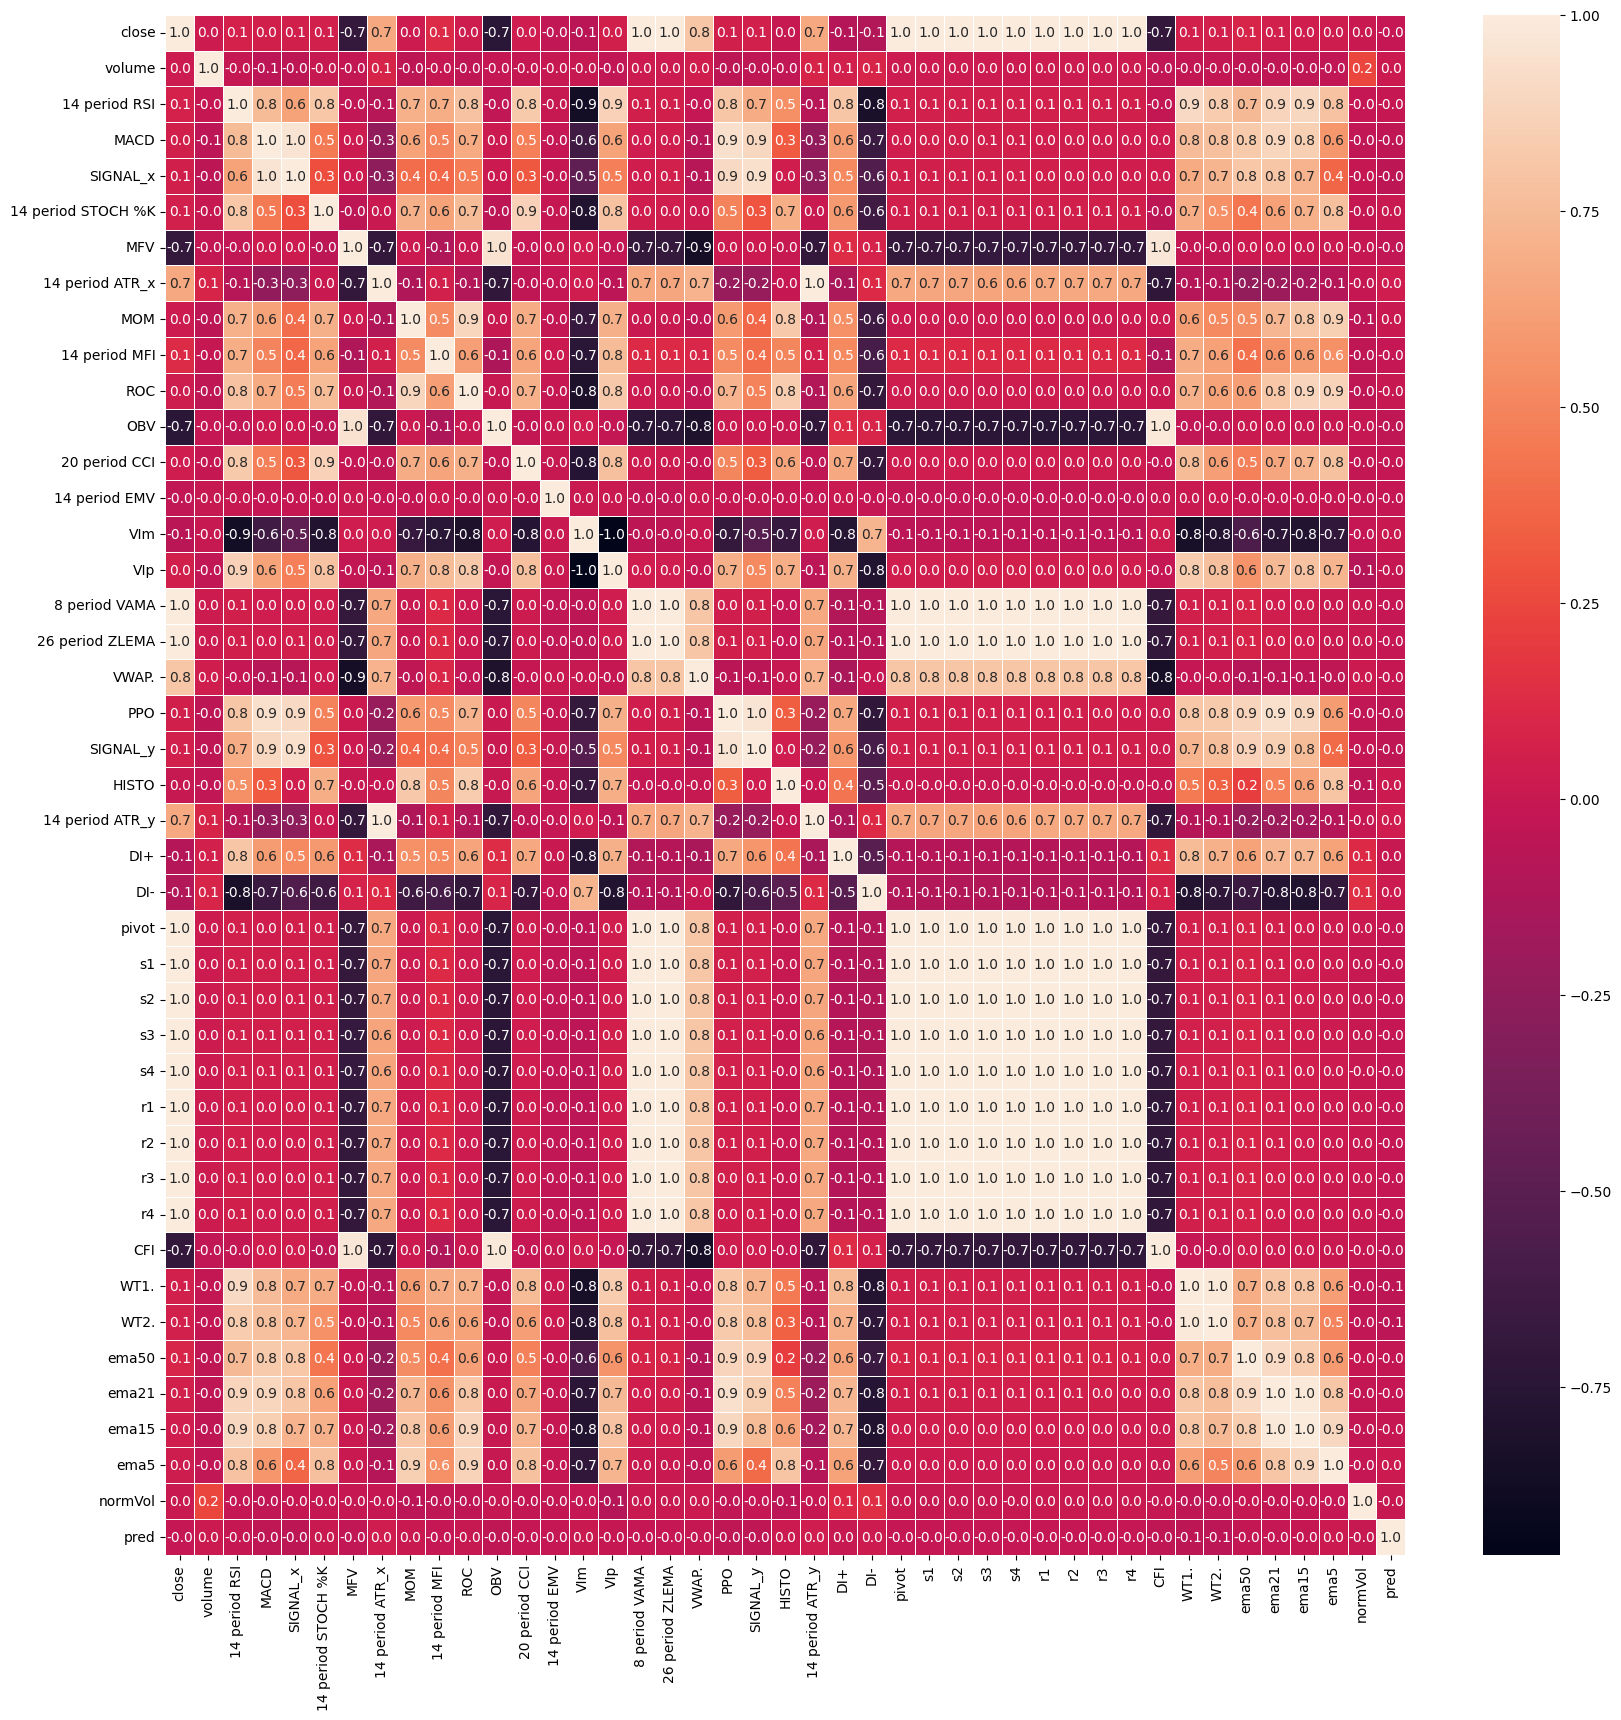

In [56]:
#cor_matrix = df.corr().abs()
#upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
#to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
#df = df.drop(columns=to_drop)
f,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

<Axes: >

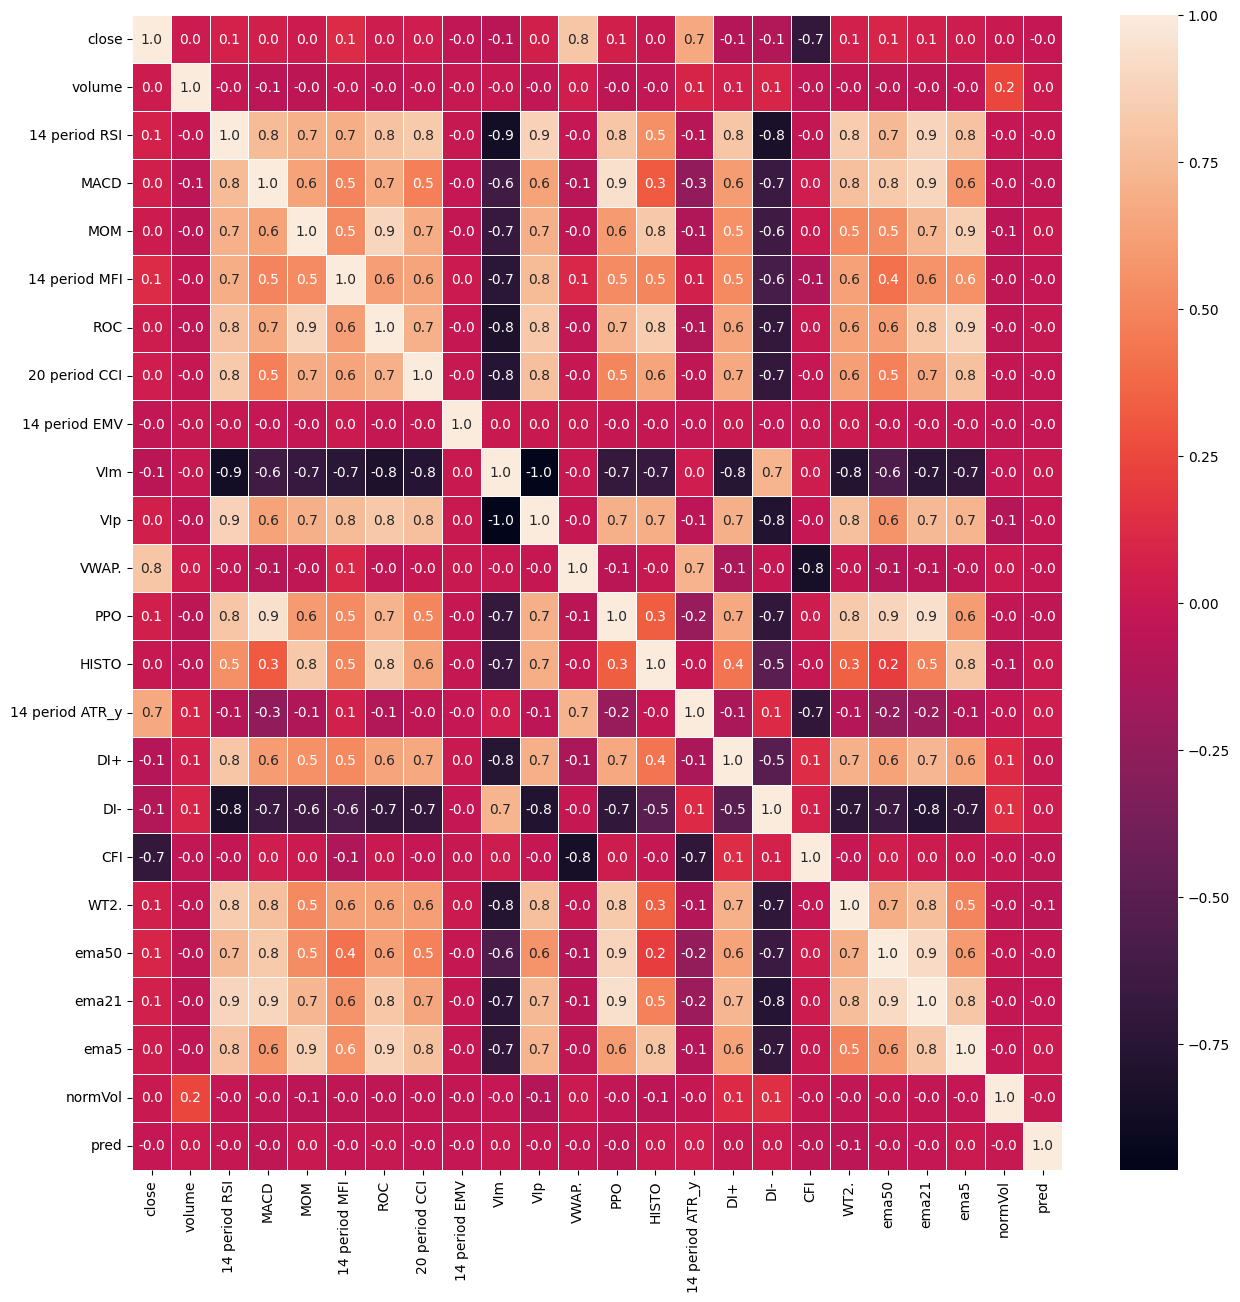

In [57]:
fremove = df[['SIGNAL_x', '26 period ZLEMA', 'MFV', 'OBV', 's1', 's2', 's3', 's4', 'r1', 'r2', 'r3', 'r4', 'WT1.', 'ema15', 'SIGNAL_y', '8 period VAMA', '14 period STOCH %K', '14 period ATR_x', 'pivot']]
df = df.drop(columns=fremove)
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [48]:
features = StandardScaler().fit_transform(df[df.columns.difference(['pred', 'date'])])
target = df['pred']

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.1, shuffle=False)
X_train.shape

(15306, 23)

{'C': 0.1, 'solver': 'saga'}
              precision    recall  f1-score   support

         0.0       0.43      0.45      0.44       772
         1.0       0.52      0.51      0.52       929

    accuracy                           0.48      1701
   macro avg       0.48      0.48      0.48      1701
weighted avg       0.48      0.48      0.48      1701

LR TEST SET - 0.47971781305114636
LR TRAIN SET - 0.5707565660525284


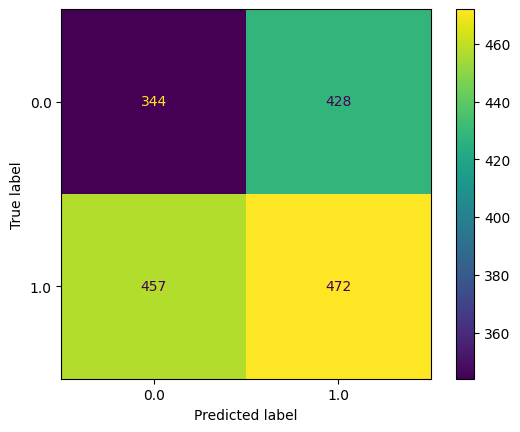

In [49]:
#knn = trained_KNN(X_train, X_test, Y_train, Y_test)
lr = trained_LogisticRegression(X_train, X_test, Y_train, Y_test)
#rfc = trained_RandomForestClassifier(X_train, X_test, Y_train, Y_test)
#vc = trained_VotingClassifier(lr, knn, X_train, X_test, Y_train, Y_test)